### 🎯 Unlearning by Confusing Layers
Vamos a entrenar un ensablado de modelos ResNet18 y evaluar la eficacia de un MIA cuando reentrenamos los modelos partiendo de un modelo base con ciertas capas _confundidas_. Estudiamos primero el caso de un único modelo reentrenado.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.utils import split_dataset
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

Using TensorFlow backend


In [2]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [3]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4254072832
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

___
Descargamos y preparamos los datos de CIFAR-10.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = split_dataset(held_out, left_size=0.2)

In [5]:
def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label

In [6]:
# Esta función divide el conjunto de datos (no convertidos en un Dataset) en 'S' trozos de igual tamaño,
# proporcionando también los conjuntos a olvidar y retener

def sliced_ds_raw(x,y,S):
    x_slices = []
    y_slices = []
    ft_set_x=[]
    ft_set_y=[]
    rt_set_x=[]
    rt_set_y=[]

    # Calculate the size of each slice
    slice_size = x.shape[0] // S
    forget_size = slice_size // 10

    for i in range(S):
        start_index = i * slice_size
        end_index = start_index + slice_size
        x_slices.append(x[start_index:end_index])
        y_slices.append(y[start_index:end_index])
        ft_set_x.append(x[start_index:start_index+forget_size])
        ft_set_y.append(y[start_index:start_index+forget_size])
        rt_set_x.append(x[start_index+forget_size:end_index])
        rt_set_y.append(y[start_index+forget_size:end_index])

    return x_slices, y_slices, ft_set_x, ft_set_y, rt_set_x, rt_set_y

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

___
Descargamos el modelo ResNet18, y lo entrenamos habiendo reinicializado ciertas capas.

In [8]:
def get_model():
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model

In [ ]:
model = keras.saving.load_model('resnet18_cifar10.keras')

___
Confusión de capas.

In [9]:
from keras.layers import Conv2D

def vision_confuser(model, std=0.1):
    # Assuming the ResNet18 backbone is the first layer of the model
    resnet_backbone = model.layers[0]
    for layer in resnet_backbone.layers:
        if isinstance(layer, Conv2D):
            weights = layer.get_weights()
            # Iterate over each array in the list
            for i, arr in enumerate(weights):
                # Generate random numbers from a normal distribution
                random_numbers = np.random.normal(0, std, size=arr.shape)
                # Add the random numbers to the original array
                weights[i] += random_numbers
            layer.set_weights(weights)

    weights = model.layers[-1].get_weights()
    # Iterate over each array in the list
    for i, arr in enumerate(weights):
        # Generate random numbers from a normal distribution
        random_numbers = np.random.normal(0, std, size=arr.shape)
        # Add the random numbers to the original array
        weights[i] += random_numbers
    model.layers[-1].set_weights(weights)


In [ ]:
base_model = tf.keras.models.clone_model(model)
base_model.set_weights(model.get_weights())
base_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
        jit_compile=True
    )

In [ ]:
confusion_std=0.06

vision_confuser(base_model, std=confusion_std)

In [ ]:
def compare_weights(model1,model2):
    # Extract the 'res_net_backbone' layer
    res_net_backbone = model1.get_layer('res_net_backbone')
    backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

    # Extract layer names and weights for the entire model
    layer_names = [layer.name for layer in model1.layers]
    layer_weights = [layer.get_weights() for layer in model1.layers]

    model1_weights = []

    for name, weights in zip(layer_names, layer_weights):
        if name == 'res_net_backbone':
            model1_weights.extend(backbone_layer_weights)
        elif weights:  # Only add layers that have weights
            model1_weights.append(weights)

        # Extract the 'res_net_backbone' layer
    res_net_backbone = model2.get_layer('res_net_backbone')
    backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

    # Extract layer names and weights for the entire model
    layer_names = [layer.name for layer in model2.layers]
    layer_weights = [layer.get_weights() for layer in model2.layers]

    model2_weights = []

    for name, weights in zip(layer_names, layer_weights):
        if name == 'res_net_backbone':
            model2_weights.extend(backbone_layer_weights)
        elif weights:  # Only add layers that have weights
            model2_weights.append(weights)

    layer_names=['conv1','0_1_1_conv','0_1_2_conv','0_2_1_conv',
    '0_2_2_conv','1_1_1_conv','1_1_0_conv','1_1_2_conv','1_2_1_conv',
    '1_2_2_conv','2_1_1_conv','2_1_0_conv','2_1_2_conv','2_2_1_conv',
    '2_2_2_conv','3_1_1_conv','3_1_0_conv','3_1_2_conv','3_2_1_conv',
    '3_2_2_conv','dense_out']

    return layer_names, model1_weights, model2_weights

In [ ]:
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

def flatten_arrays(arrays):
    flattened_elements = []
    for arr in arrays:
        flattened_elements.extend(arr.flatten())
    return flattened_elements

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

In [ ]:
layer_names, model1_wights, model2_weghts = compare_weights(model,base_model)

# Initialize list to store cosine similarities
similarities = []

# Compute cosine similarity for each layer
for w1, w2 in zip(model1_wights, model2_weghts):
    w1=flatten_arrays(w1)
    w2=flatten_arrays(w2)
    similarity = cos_sim(w1, w2)
    similarities.append(similarity)

# Plotting
plt.figure(figsize=(5, 3))
plt.barh(layer_names, similarities, color='skyblue', capsize=5)
plt.xlabel('Cosine Similarity')
plt.ylabel('Layers')
plt.title('Cosine similarity between weight arrays of models')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()

plt.show()

In [10]:
Slices=16 # slices

x_slices, y_slices, ft_set_x, ft_set_y, rt_set_x, rt_set_y = sliced_ds_raw(x_train, y_train, Slices)
sliced_datasets=[]
ft_datasets=[]
rt_datasets=[]

for i in range(Slices):
    ds=tf.data.Dataset.from_tensor_slices((x_slices[i], y_slices[i]))
    sliced_datasets.append(ds)

    ds=tf.data.Dataset.from_tensor_slices((ft_set_x[i], ft_set_y[i]))
    ft_datasets.append(ds)

    ds=tf.data.Dataset.from_tensor_slices((rt_set_x[i], rt_set_y[i]))
    rt_datasets.append(ds)

for i in range(Slices):
    sliced_datasets[i] = sliced_datasets[i].map(normalize)
    sliced_datasets[i] = sliced_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    sliced_datasets[i] = sliced_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)

    ft_datasets[i] = ft_datasets[i].map(normalize)
    ft_datasets[i] = ft_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    ft_datasets[i] = ft_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)

    rt_datasets[i] = rt_datasets[i].map(normalize)
    rt_datasets[i] = rt_datasets[i].shuffle(buffer_size=8*BATCH_SIZE)
    rt_datasets[i] = rt_datasets[i].batch(BATCH_SIZE).prefetch(AUTOTUNE)

___
_Unlearning model_

In [11]:
""" models = []

for s in range(Slices):
    save_path = 'confused_ensembles/'+str(Slices)+'_sliced_models/retain_slice_'+str(s)+'.keras'
    model_copy=keras.saving.load_model(save_path)
    
    models.append(model_copy)
    print(f"Finished iteration {s}") """

Finished iteration 0
Finished iteration 1
Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15


In [ ]:
models = []

for s in range(13, Slices):
    model_copy = tf.keras.models.clone_model(base_model)
    model_copy.set_weights(base_model.get_weights())
    model_copy.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    models.append(model_copy)

    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)
    
    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=2)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=4)

    """ model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=1)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=2)

    vision_confuser(model_copy, std=confusion_std)
    model_copy.fit(rt_datasets[s], validation_data=val_ds, epochs=4) """

    save_path = 'confused_ensembles/'+str(Slices)+'_sliced_models/retain_slice_'+str(s)+'.keras'
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    model_copy.save(save_path, save_format="keras_v3")

    print(f"Finished iteration {s}")

In [12]:
# Ensamblado de los 'S' modelos en uno, cuyo output es la media de los todos

for s in range(Slices):
    models[s]._name='sequential_'+str(s)
    print(models[s]._name)
    
model_input = tf.keras.Input(shape=(32, 32, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
unlearn_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

unlearn_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

sequential_0
sequential_1
sequential_2
sequential_3
sequential_4
sequential_5
sequential_6
sequential_7
sequential_8
sequential_9
sequential_10
sequential_11
sequential_12
sequential_13
sequential_14
sequential_15


___
Cuantificamos la calidad del algoritmo de desaprendizaje a través de un _membership inference attack_ simple (MIA).

Este MIA consiste en un modelo de regresión logística que predice si el modelo fue entrenado en una muestra particular a partir del _loss_ de esa muestra. Para tener una idea de la dificultad de este problema, primero graficamos a continuación un histograma de los _loss_-es del modelo preentrenado en el conjunto de entrenamiento y prueba.

In [13]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        reduction="none"
    )
    all_losses = []

    for inputs, targets in tqdm(loader):
        logits = net(inputs, training=False)
        losses = loss_fn(targets, logits).numpy()
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [14]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [27]:
retain_ds = rt_datasets[0]
for dataset in rt_datasets[1:]:
    retain_ds = retain_ds.concatenate(dataset)

forget_ds = ft_datasets[0]
for dataset in ft_datasets[1:]:
    forget_ds = forget_ds.concatenate(dataset)

# Análisis de la exactitud en el conjunto de datos
print(f"Train set accuracy: {100.0 * unlearn_model.evaluate(train_ds)[-1]:0.1f}%%")
print(f"Retain set accuracy: {100.0 * unlearn_model.evaluate(retain_ds)[-1]:0.1f}%%")
print(f"Forget set accuracy: {100.0 * unlearn_model.evaluate(forget_ds)[-1]:0.1f}%%")
print(f"Validation set accuracy: {100.0 * unlearn_model.evaluate(val_ds)[-1]:0.1f}%%")
print(f"Test set accuracy: {100.0 * unlearn_model.evaluate(test_ds)[-1]:0.1f}%%")

391/391 [==============================] - 14s 35ms/step - loss: 0.7807 - accuracy: 0.7406
Train set accuracy: 74.1%%
352/352 [==============================] - 13s 35ms/step - loss: 0.7688 - accuracy: 0.7449
Retain set accuracy: 74.5%%
48/48 [==============================] - 2s 40ms/step - loss: 0.8882 - accuracy: 0.7027
Forget set accuracy: 70.3%%
63/63 [==============================] - 2s 36ms/step - loss: 0.9616 - accuracy: 0.6812
Validation set accuracy: 68.1%%
16/16 [==============================] - 1s 32ms/step - loss: 0.9522 - accuracy: 0.6790
Test set accuracy: 67.9%%


In [17]:
forget_losses = compute_losses(unlearn_model, forget_ds)
test_losses = compute_losses(unlearn_model, test_ds)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[:len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA attack has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

100%|██████████| 16/16 [00:13<00:00,  1.20it/s]

The MIA attack has an accuracy of 0.496 on forgotten vs unseen images


In [20]:
confusion_std=0.06

In [21]:
# Getting back the objects:
with open('SNIsA_unconla.pkl', 'rb') as f:
    [confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score] = pickle.load(f)

confusion_stds[3].append(confusion_std)
accuracy_retain[3].append(unlearn_model.evaluate(retain_ds)[-1])
accuracy_forget[3].append(unlearn_model.evaluate(forget_ds)[-1])
accuracy_test[3].append(unlearn_model.evaluate(test_ds)[-1])
mia_score[3].append(mia_scores.mean())

# Saving the objects:
with open('SNIsA_unconla.pkl', 'wb') as f:
    pickle.dump([confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score], f)

16/16 [==============================] - 1s 34ms/step - loss: 0.9522 - accuracy: 0.6790


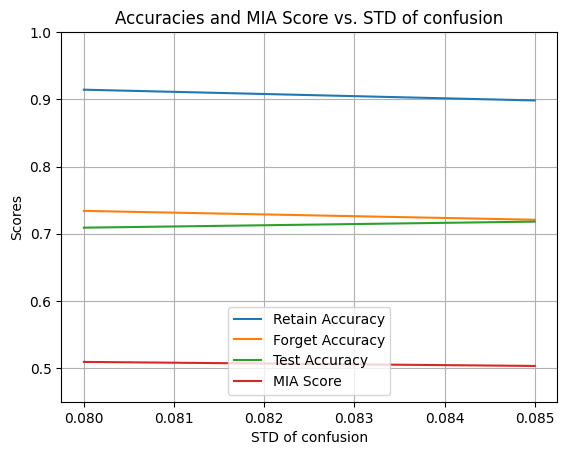

In [26]:
plt.plot(confusion_stds[0], accuracy_retain[0], label='Retain Accuracy')
plt.plot(confusion_stds[0], accuracy_forget[0], label='Forget Accuracy')
plt.plot(confusion_stds[0], accuracy_test[0], label='Test Accuracy')
plt.plot(confusion_stds[0], mia_score[0], label='MIA Score')

plt.xlabel('STD of confusion')
plt.ylabel('Scores')
plt.title('Accuracies and MIA Score vs. STD of confusion')
plt.legend()
plt.grid(True)
plt.gca().set_ylim(0.45,1)
plt.show()

In [ ]:
""" c=[[],[],[],[]]
accuracy_retain=[[],[],[],[]]
accuracy_forget=[[],[],[],[]]
accuracy_test=[[],[],[],[]]
mia_score=[[],[],[],[]]

# Saving the objects:
with open('SNIsA_unconla.pkl', 'wb') as f:
    pickle.dump([confusion_stds, accuracy_retain, accuracy_forget, accuracy_test, mia_score], f) """